In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2 

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard,CSVLogger
img_width=512 # 2048
img_height=512 # 2048

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
defect_folder= '/content/drive/MyDrive/dataset_train/spay_defects_half'
#defect_folder= '/content/drive/MyDrive/dataset_train/spray_defects'

In [4]:
normal_folder= '/content/drive/MyDrive/dataset_train/normal_half'
#normal_folder= '/content/drive/MyDrive/dataset_train/normal'

In [5]:
import tensorflow as tf
from tensorflow import keras

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.99
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [6]:
def normalize(img):
    min = img.min()
    max = img.max()
    return 2.0 * (img - min) / (max - min) - 1.0

In [7]:
def norm_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if not filename.startswith('.'):
            img=cv2.imread(os.path.join(folder,filename))[:2048,:2048,:3]#2048
            #print('Original Dimensions : ',img.shape)
            dim = (img_width, img_height)
            resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            #print('Resized Dimensions : ',resized.shape)
      #      img = cv2.fastNlMeansDenoising(img,50,50,20,21) 
            img = normalize(resized)
            if img is not None:
                images.append(img)
    return images

In [8]:
img_defects_norm=norm_images_from_folder(defect_folder)

In [9]:
img_clean_norm=norm_images_from_folder(normal_folder)

In [10]:
img_all=img_defects_norm+img_clean_norm
Y=[1]*len(img_defects_norm)+[0]*len(img_clean_norm)
np.save("img_all.npy",img_all)
np.save("Y_all.npy",Y)


In [11]:
img_all=np.load("img_all.npy")
Y=np.load("Y_all.npy")

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_all, Y, 
                    test_size=0.2, stratify = Y, random_state=0)

In [13]:
y_train=np.array(y_train)
y_test=np.array(y_test)
X_train=np.array(X_train)
X_test=np.array(X_test)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
print(y_train[:10])

(177, 512, 512, 3) (177,) (45, 512, 512, 3) (45,)
[1 1 1 0 1 0 1 0 1 0]


In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(pooling='max',
    input_shape=(512, 512, 3), include_top=False)
pre_trained_model.load_weights(local_weights_file)

In [16]:
for layer in pre_trained_model.layers[0:305]:#total 311 layers for Inception3, so just keeping last 5 layer flexible
#for layer in pre_trained_model.layers:
    layer.trainable = False
count=1
for layer in pre_trained_model.layers:
    count+=1
    print(count,layer, layer.trainable)

from tensorflow.keras.optimizers import SGD

unfreeze = False
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed7':
    unfreeze = True

2 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f516951f550> False
3 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f516951fb50> False
4 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f5169514310> False
5 <tensorflow.python.keras.layers.core.Activation object at 0x7f5169529290> False
6 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f51695299d0> False
7 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f51694ae1d0> False
8 <tensorflow.python.keras.layers.core.Activation object at 0x7f51694af110> False
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f51694bb790> False
10 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f51699d1110> False
11 <tensorflow.python.keras.layers.core.Activation object at 0x7f5169a8b9d0> False
12 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f51694c3150> False
13 <tens

In [17]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 30, 30, 768)


In [18]:
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 255, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 255, 255, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 255, 255, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [22]:
model_path = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
early_stopping = EarlyStopping(patience=5)
model_checkpoint = ModelCheckpoint(model_path,
                                   save_best_only=True, save_weights_only=True)

csv_logger = CSVLogger("InceptionV3.csv", append=True)
#name='vgg19_denoise'
tensorboard = TensorBoard(log_dir='InceptionV3_log')

def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 :
    return 1e-4

history = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                     epochs=15,batch_size=3, shuffle=True,
                     verbose=2,
                     callbacks=[model_checkpoint, early_stopping,csv_logger,
                                tf.keras.callbacks.LearningRateScheduler(decay),tensorboard])



Epoch 1/15
59/59 - 162s - loss: 22.7036 - acc: 0.6667 - val_loss: 8.6069 - val_acc: 0.6667
Epoch 2/15
59/59 - 151s - loss: 8.8830 - acc: 0.7910 - val_loss: 56.2354 - val_acc: 0.4889
Epoch 3/15
59/59 - 153s - loss: 7.2286 - acc: 0.8531 - val_loss: 5.1820 - val_acc: 0.8444
Epoch 4/15
59/59 - 150s - loss: 1.6562 - acc: 0.8983 - val_loss: 4.6210 - val_acc: 0.8444
Epoch 5/15
59/59 - 161s - loss: 0.9886 - acc: 0.9548 - val_loss: 6.5808 - val_acc: 0.8667
Epoch 6/15
59/59 - 154s - loss: 1.1490 - acc: 0.9492 - val_loss: 4.8671 - val_acc: 0.8444
Epoch 7/15
59/59 - 153s - loss: 0.6284 - acc: 0.9492 - val_loss: 6.9270 - val_acc: 0.8667
Epoch 8/15
59/59 - 151s - loss: 0.2882 - acc: 0.9718 - val_loss: 5.8352 - val_acc: 0.8667
Epoch 9/15
59/59 - 158s - loss: 0.2034 - acc: 0.9831 - val_loss: 5.9733 - val_acc: 0.8667


NameError: ignored

In [23]:
pred=model.predict(X_test)
pred_Y=np.argmax(pred,axis=1)
print("pred:", pred_Y)
print("actual:", y_test)

pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
actual: [0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0
 1 1 1 1 0 1 1 0]


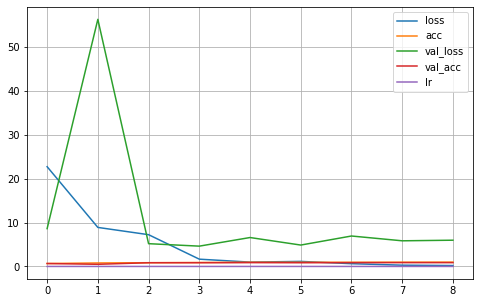

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
#Adding custom Layers
x = model.output
x = GlobalAveragePooling2D()(x)
#x = max_pool_2d(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(5,activation='softmax')(x)
predictions = Dense(1, activation="sigmoid")(x)
# creating the final model 
model_final = Model(model.input, predictions)
model_final.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])#change for F1score
                   # options = run_opts,
                   # run_metadata=runmeta)

print(model_final.summary())

In [ ]:
model_path = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
early_stopping = EarlyStopping(patience=5)
model_checkpoint = ModelCheckpoint(model_path,
                                   save_best_only=True, save_weights_only=True)

csv_logger = CSVLogger("InceptionV3.csv", append=True)
#name='vgg19_denoise'
tensorboard = TensorBoard(log_dir='InceptionV3_log')

def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 :
    return 1e-4

history = model_final.fit(X_train, y_train,validation_data=(X_test, y_test),
                     epochs=10,batch_size=3, shuffle=True,
                     verbose=2,
                     callbacks=[model_checkpoint, early_stopping,csv_logger,
                                tf.keras.callbacks.LearningRateScheduler(decay),tensorboard])



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
pred=model_final.predict(X_test)
pred_Y=np.argmax(pred,axis=1)
print("pred:", pred_Y)
print("actual:", y_test)